# Are Stock Prices Random?

In this notebook we will build a statistical test to reject (or fail to) the hypothesis that daily stock prices change like a random walk.

The test was developed by Andrew W. Lo, A. Craig MacKinlay, 1988 (Paper: [Stock Market Prices Do Not Follow Random Walks: Evidence from a Simple Specification Test](https://doi.org/10.1093/rfs/1.1.41)) and the notebook is a modified version of an R notebook from the MIT Micro Masters in Finance (MITx 15.455x - Mathematical Methods for Quantitative Finance)

# Basic Definitions

## Random Walk

A process $X_t = r_1 + ... + r_t$ is called a **random walk** if the following conditions are satisfied:

1. $r_t = \sigma z_t + \mu$
2. Each $z_t$ is a random variable identically distributed
3. Their Expectation ($E[\cdot]$) follows:
    
    a. $E[z_t] = 0$
    
    b. $E[z_t^2] = 1$
    
    c. $E[z_t\cdot z_{t'}] = 0$ if $t \neq t'$    


## Price Series

Define the geometric price series $\{P_t\}$ as follows:

$$P_t = P_0 e^{r_1 + ... + r_t}$$

Note that, in this way we have $$r_t  = log(\frac{P_t}{P_{t-1}}) = log(P_t) - log(P_{t-1}$$


In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"

import pandas as pd
import seaborn as sns
import numpy as np

In [3]:
# We wil download data from yahoo finance, uncomment the following lines if you do not have these modules installed
# !pip install yfinance
# !pip install yahoofinancials

In [2]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

In [83]:
ticker_name = "TR" # Change here for any Ticker name you wanna check yourself
data = yf.download(ticker_name)

[*********************100%***********************]  1 of 1 completed


In [84]:
_filter = data.index > "1987-12-31"
_filter &= data.index <= "2017-12-31"

data = data[_filter].copy()


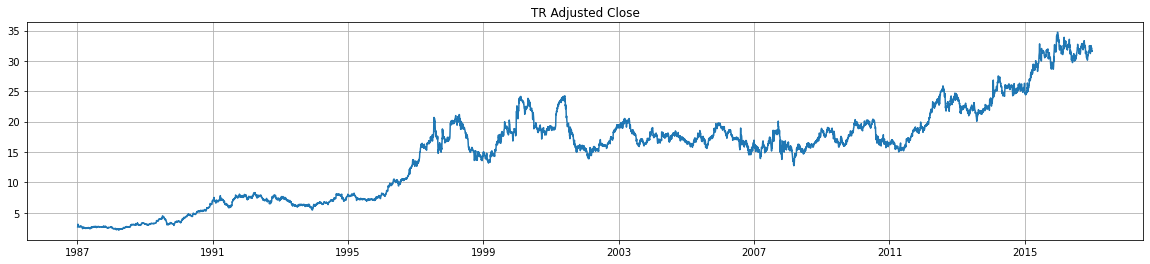

In [86]:
plt.plot(data.index, data["Adj Close"])
_ = plt.title(f"{ticker_name} Adjusted Close")
plt.grid()

Since we will test random walk on the returns (and not price), let's add an extra column  for the log returns ($r$) as:

$$r_t=log(P_t/P_{t−1})=log(P_t/P_0)−log(P_{t−1}/P_0)$$

In [87]:
data["r"] = data["Adj Close"].apply(np.log).diff()
data = data.dropna() # drop first nan row due to diff

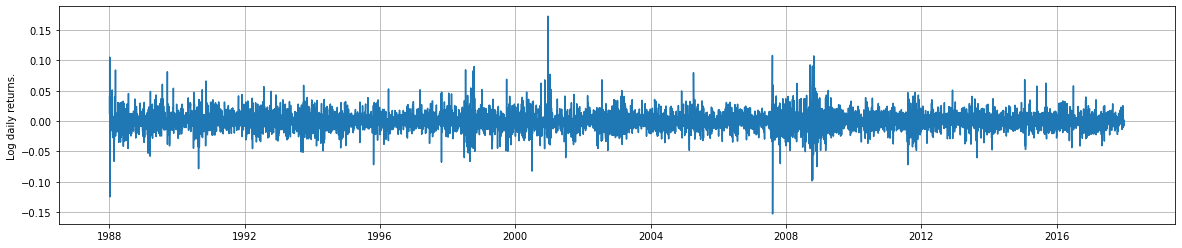

In [88]:
plt.plot(data.r)
plt.ylabel("Log daily returns.")
plt.grid()
ymin, ymax = plt.ylim() # save y-axis limits for next plot

If the ticker is a random walk the plot above should be evenly distributed. Often we can see a few spikes that might suggest that the price is not random. 

Below see a normal distribution with the same volatility as above. We can use this as a benchmark.

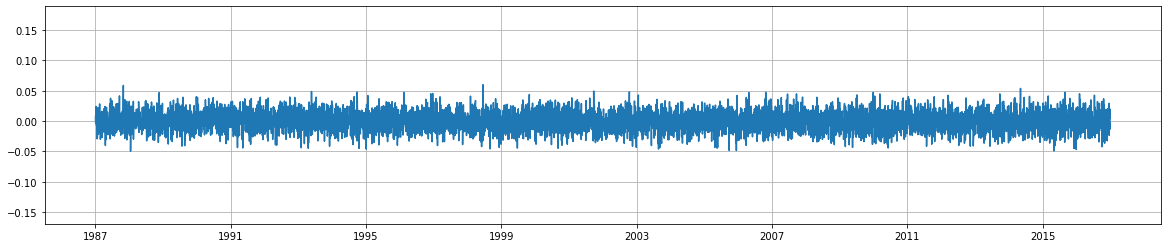

In [89]:
np.random.seed(42) # set seed for reproducibility
plt.plot(data.index, data.r.std()*np.random.normal(size=len(data)))
_ = plt.ylim(ymin, ymax)
plt.grid()

# Summary statistics and return distribution

In [90]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,r
count,7560.000000,7560.000000,7560.000000,7560.000000,7560.000000,7.560000e+03,7560.000000
mean,18.172413,18.346309,17.992950,18.175406,15.078679,1.030732e+05,0.000327
std,8.095417,8.173092,8.009936,8.094365,7.648537,1.290910e+05,0.015261
min,3.393280,3.426877,3.359683,3.359683,2.167201,0.000000e+00,-0.152747
25%,10.079049,10.196638,10.011855,10.079049,7.463040,4.092600e+04,-0.007796
50%,20.012646,20.210371,19.763548,20.004527,16.403297,7.786850e+04,0.000000
75%,23.374553,23.617056,23.177715,23.406574,19.113140,1.294695e+05,0.008097
max,36.605667,37.005486,36.205849,36.916637,34.719765,6.550235e+06,0.172633


# Annualization conventions

As usual, let's focus on annualized returns and volatility. 

In [91]:
trading_days = 252 # 21 trading days per month, 12 months

In [92]:
data.r.mean()*trading_days

0.08251021409736824

In [93]:
data.r.std()*np.sqrt(trading_days)

0.2422687667865867

Another red flag when it comes to testing for randomness is the fat tails (when compared to the bell-shaped normal distribution) for the lof returns distribution. See below

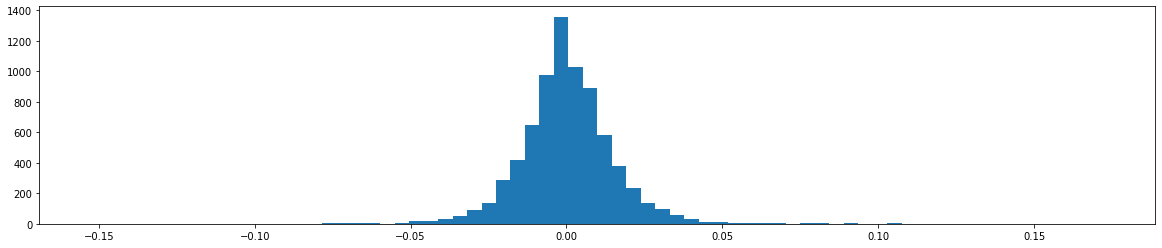

In [99]:
_ = plt.hist(data.r, bins=70)
plt.title("Log returns distribution")

# Formal test: Andrew W. Lo, A. Craig MacKinlay, 1988
Paper: [Stock Market Prices Do Not Follow Random Walks: Evidence from a Simple Specification Test](https://doi.org/10.1093/rfs/1.1.41)

Let's follow the instructions in this 1988 paper to formally test for randomness


The estimator proposed by the authors for testing the market price for random walk (with constant volatility) is called *Variance Ratio*. 

Naively, the idea is that if the stock price is a random walk, the variance should grow linearly with the size of the sampling window. If we cannot observe this linear increase, we should reject the hypothesis that the stock price is draw from a random distribution. 

We formalize this with the following equations:

Denote by $$r_{t,n} \doteq log(P_t/P_{t-n}) = log(P_t) - log(P_{t-n}) $$

Lemma: $Var(r_{t,n}) = n \cdot VAR(r_t)$. To prove this last equality note that $R_{t,n} = \sum_{i = t -n +1}^{i=t}r_i$.


$$\text{(Variance Ratio) } \frac{Var(r_{t,n})}{nVar(r_t)} = 1$$


In [217]:
variances = []

variance_base = np.log(data["Adj Close"]).diff().var()

for n in range(2,100):
  _slices = np.arange(0,len(data["Adj Close"]), n)
  variances.append( np.log(data["Adj Close"][_slices]).diff().var() )

See below the Variance ratio growing somewhat linearly with the sampling window. But we can see some noise with bigger time windows.

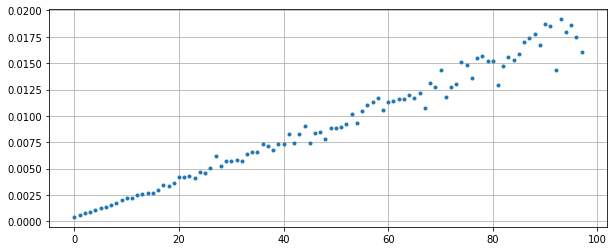

In [218]:
_ = plt.figure(figsize=(10,4))
plt.plot(variances, ".")
plt.grid()

How the estimator behaves?

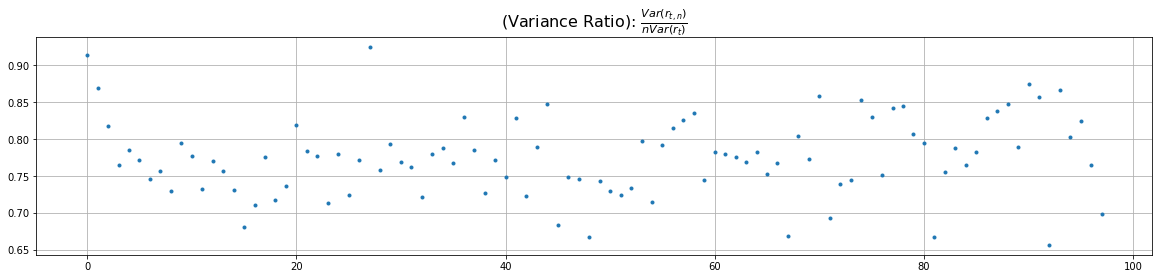

In [221]:
plt.plot([variances[n]/((n+2)*variance_base) for n in range(0,len(variances))], ".")
plt.grid()
_ = plt.title("(Variance Ratio): $ \\frac{Var(r_{t,n})}{nVar(r_t)}$", fontsize=16)

In [254]:

def var_c(X, q):
  T = len(X)
  mu = (X[T-1] - X[0])/T # equation (4a) from paper
  m = (T-q) * (T-q+1)*q/T  # equation (12b) from paper
  sums_q = 0
  for k in range(q,T):
    sums_q += (X[k] - X[k-q] - q*mu)**2 # equation (12b top) from paper
  return sums_q/m

def z_score(X, q):
  T = len(X)
  M_r = var_c(X,q)/var_c(X,1) - 1  
  z = np.sqrt(T) * M_r * np.sqrt( (3*q)/(2*(2*q-1)*(q-1)) ) # last line, page 47
  return z

zstats = []
for i in range(2,50):
  zstats.append(z_score(np.log(data["Adj Close"].values), i))


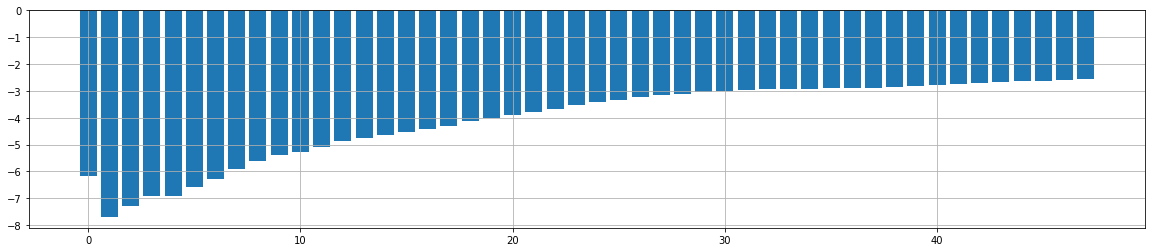

In [255]:
_ = plt.bar(range(len(zstats)), zstats)
plt.grid()

In [256]:
max(zstats)

-2.5562163290898754

**Interpreting the results**
According to the reference paper, the statistic $z(q)$ was constructed in such a way that $z(q) \sim  N(0,1)$, since all values are smaller than $-2$, we can reject the null hypothesis (log of returns is a random walk) at the 5% level of significance.